In [161]:
# library for feature engineering and EDA
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
#import pandas_profiling
from datetime import datetime
import random

# library for statistic
from scipy import stats
from scipy.stats import chi2_contingency, kruskal
from scipy.stats import boxcox, norm
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.formula.api import ols

# library for sampling
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE

# library for machine learning
import sklearn
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

import shap
%matplotlib inline

In [162]:
random_state = 1234

In [163]:
df = pd.read_csv("../../../../mlops_data/mlflow/application_record.csv")
df_record = pd.read_csv("../../../../mlops_data/mlflow/credit_record.csv")
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [164]:
df_record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [165]:
df_record.sort_values(["ID", "MONTHS_BALANCE"], ascending=False).groupby("ID").first()

,MONTHS_BALANCE,STATUS
ID,,
5001711,0,X
5001712,0,C
5001713,0,X
5001714,0,X
5001715,0,X
...,...,...
5150482,-11,C
5150483,0,X
5150484,0,C


In [166]:
print(len(df[df.duplicated()]))
print(len(df_record[df_record.duplicated()]))

0
0


In [167]:
len(df)

438557

In [168]:
df.merge(df_record, on="ID", how="inner").head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,C


In [169]:
len(df.merge(df_record, on="ID", how="inner"))

777715

In [170]:
print(len(df_record))
print(df_record['ID'].nunique())

1048575
45985


In [171]:
df_record_filtered = df_record.sort_values(["ID", "MONTHS_BALANCE"], ascending=False).groupby("ID").first()
df_record_filtered.head(1)

,MONTHS_BALANCE,STATUS
ID,,
5001711,0,X


In [172]:
df = df.merge(df_record_filtered, on="ID", how="inner")

In [173]:
df.STATUS.unique()

array(['C', '0', 'X', '1', '5', '3', '4', '2'], dtype=object)

In [174]:
condition_no_approval = df.STATUS.isin(["0", "1", "2", "3", "4", "5"])
df["Target_Status"] = None

df.loc[condition_no_approval, "Target_Status"] = 0
df.loc[~condition_no_approval, "Target_Status"] = 1

In [175]:
df.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,Target_Status
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,0,C,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,-4542,1,1,0,0,NaN,2.0,0,C,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,-1134,1,0,0,0,Security staff,2.0,0,C,1
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,0,0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,-3051,1,0,1,1,Sales staff,1.0,-22,X,1


In [176]:
df = df.drop("STATUS", axis=1)

In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 

In [178]:
df.isna().sum().sort_values(ascending=False)


OCCUPATION_TYPE        11323
ID                         0
CODE_GENDER                0
MONTHS_BALANCE             0
CNT_FAM_MEMBERS            0
FLAG_EMAIL                 0
FLAG_PHONE                 0
FLAG_WORK_PHONE            0
FLAG_MOBIL                 0
DAYS_EMPLOYED              0
DAYS_BIRTH                 0
NAME_HOUSING_TYPE          0
NAME_FAMILY_STATUS         0
NAME_EDUCATION_TYPE        0
NAME_INCOME_TYPE           0
AMT_INCOME_TOTAL           0
CNT_CHILDREN               0
FLAG_OWN_REALTY            0
FLAG_OWN_CAR               0
Target_Status              0
dtype: int64

In [179]:
for column_name in list(df.columns):
    print(column_name, df[column_name].dtype, df[column_name].unique())

ID int64 [5008804 5008805 5008806 ... 5149838 5150049 5150337]
CODE_GENDER object ['M' 'F']
FLAG_OWN_CAR object ['Y' 'N']
FLAG_OWN_REALTY object ['Y' 'N']
CNT_CHILDREN int64 [ 0  1  3  2  4  5 14 19  7]
AMT_INCOME_TOTAL float64 [ 427500.   112500.   270000.   283500.   135000.   130500.   157500.
  405000.   211500.   360000.   126000.   315000.   247500.   297000.
  225000.   166500.   216000.   255150.   148500.   202500.    94500.
  450000.   180000.    90000.   765000.   382500.   144000.   229500.
  292500.    74250.    40500.   337500.   193500.   267750.   139500.
   67500.   252000.   900000.   115290.   279000.    76500.   234000.
   81000.   108000.    99000.   198000.    45000.   238500.   117000.
  153000.  1350000.   445500.   495000.    85500.   306000.   562500.
  189000.   328500.   310500.   540000.   171000.   675000.   121500.
   72000.    65250.   184500.   103500.   162000.   165150.    54000.
  243000.   256500.    33300.   697500.   101250.    58500.   110250.
  

In [180]:
list_cast_object = ["ID", "FLAG_MOBIL", "FLAG_WORK_PHONE", "FLAG_PHONE", "FLAG_EMAIL"]

for column_name in list_cast_object:
    df[column_name] = df[column_name].astype(object)

In [181]:
list_categorical_columns = list(df.select_dtypes(include=['object']).columns)
list_numeric_columns = list(df.select_dtypes(include=['float64', 'int64']).columns)
target_column = "Target_Status"
print(len(df))
print(len(df.columns))
print(len(list_categorical_columns))
print(len(list_numeric_columns))

36457
20
14
6


In [182]:
list_categorical_columns.remove(target_column)

In [183]:
df[target_column].describe()

count     36457
unique        2
top           1
freq      27619
Name: Target_Status, dtype: int64

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='Target_Status', ylabel='count'>

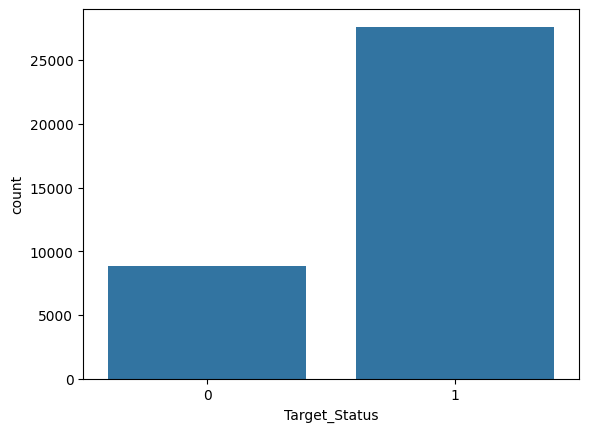

In [184]:
sns.countplot(x=target_column, data=df)

In [185]:
df[list_categorical_columns].nunique().sort_values()

FLAG_MOBIL                 1
CODE_GENDER                2
FLAG_OWN_CAR               2
FLAG_OWN_REALTY            2
FLAG_WORK_PHONE            2
FLAG_PHONE                 2
FLAG_EMAIL                 2
NAME_INCOME_TYPE           5
NAME_EDUCATION_TYPE        5
NAME_FAMILY_STATUS         5
NAME_HOUSING_TYPE          6
OCCUPATION_TYPE           18
ID                     36457
dtype: int64

In [186]:
df = df.drop(["ID", "FLAG_MOBIL"], axis=1)

In [187]:
list_categorical_columns.remove('ID')
list_categorical_columns.remove('FLAG_MOBIL')

In [188]:
df[list_categorical_columns].nunique().sort_values()

CODE_GENDER             2
FLAG_OWN_CAR            2
FLAG_OWN_REALTY         2
FLAG_WORK_PHONE         2
FLAG_PHONE              2
FLAG_EMAIL              2
NAME_INCOME_TYPE        5
NAME_EDUCATION_TYPE     5
NAME_FAMILY_STATUS      5
NAME_HOUSING_TYPE       6
OCCUPATION_TYPE        18
dtype: int64

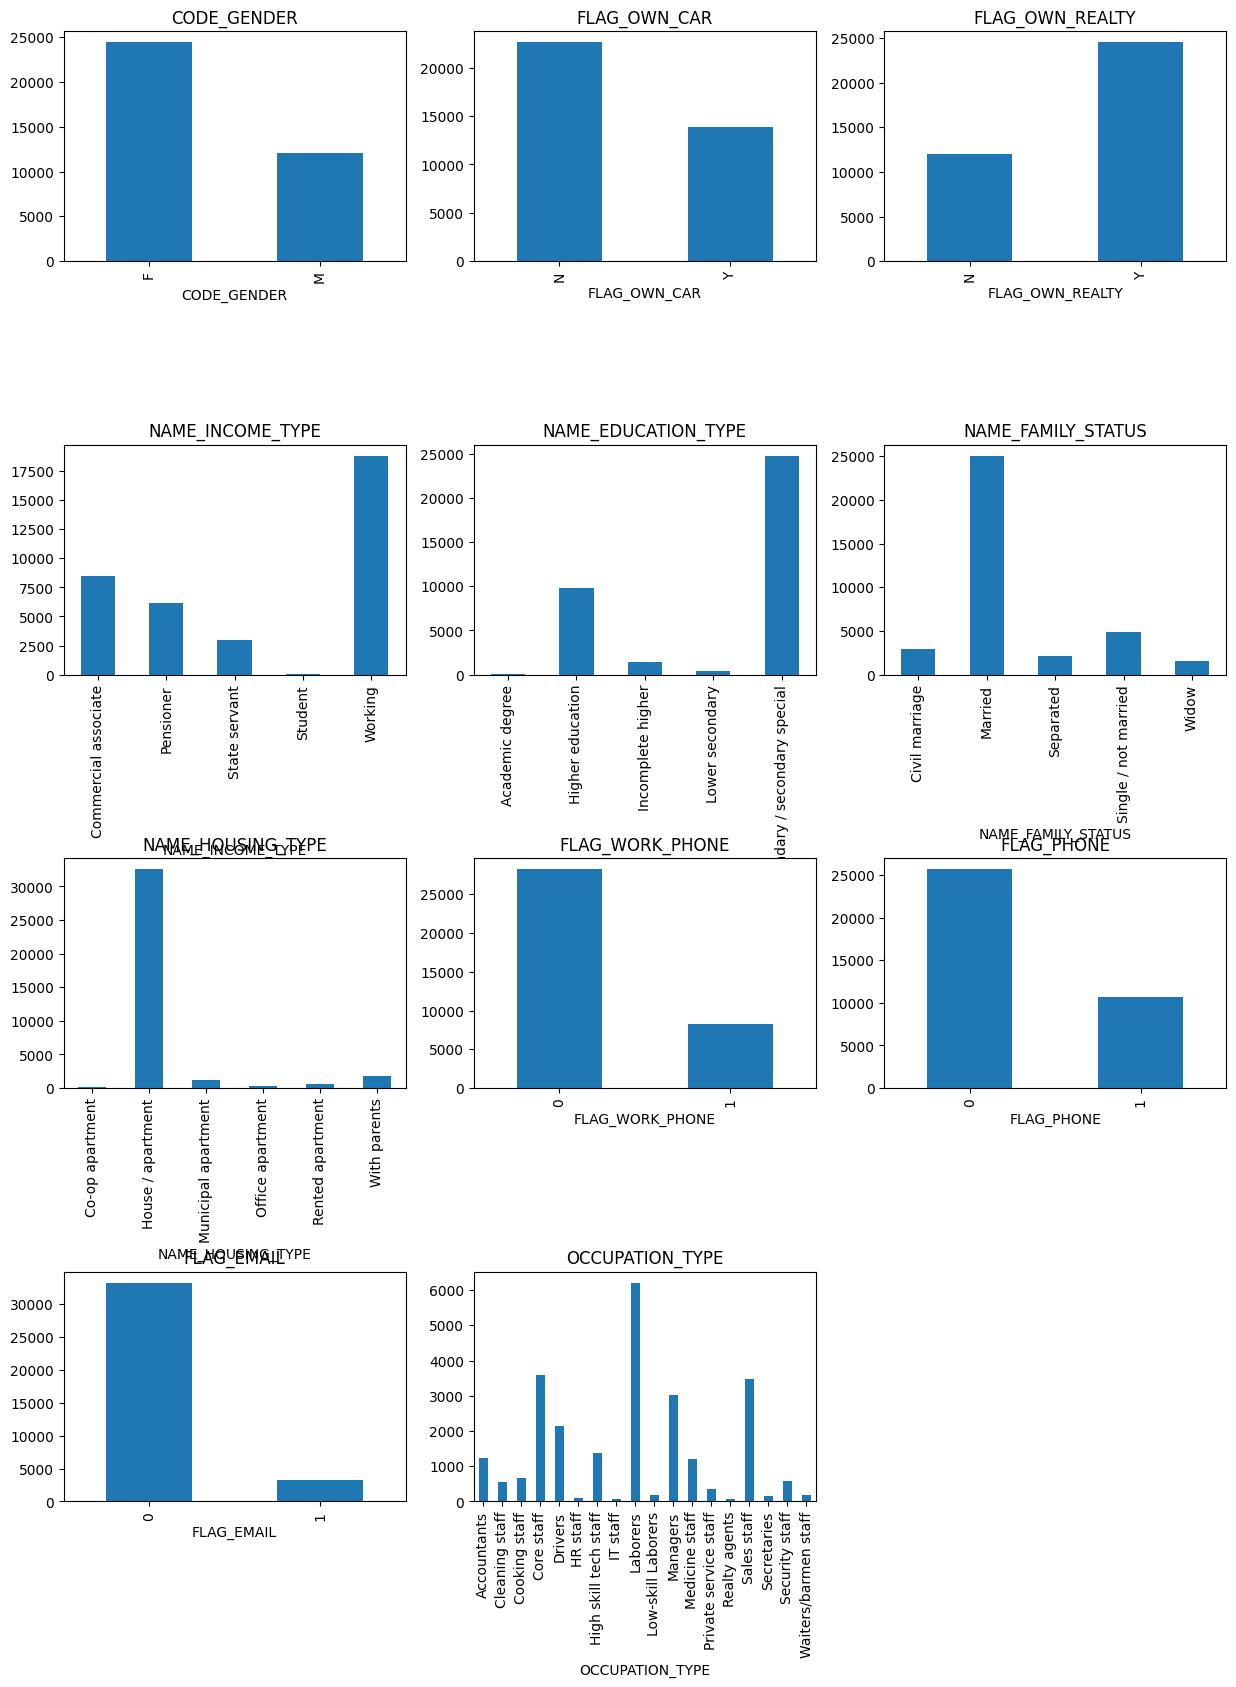

In [189]:
plt.figure(figsize=(15, 15))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.8, wspace=0.2)
for column_name in list_categorical_columns:
    plt.subplot(4, 3, x)
    x = x + 1
    df[column_name].value_counts().sort_index().plot(kind='bar')
    plt.title(column_name)
plt.show()

<Axes: xlabel='CODE_GENDER'>

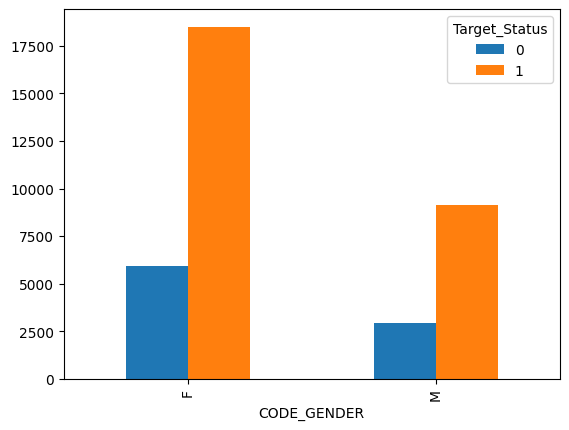

In [190]:
df_poutcome_dependent = pd.crosstab(df[list_categorical_columns[0]], df[target_column])
df_poutcome_dependent.plot(kind='bar')

In [191]:
pd.crosstab(df[list_categorical_columns[0]], df[target_column], normalize='index')

Target_Status,0,1
CODE_GENDER,,
F,0.242448,0.757552
M,0.242371,0.757629


<Axes: xlabel='CODE_GENDER'>

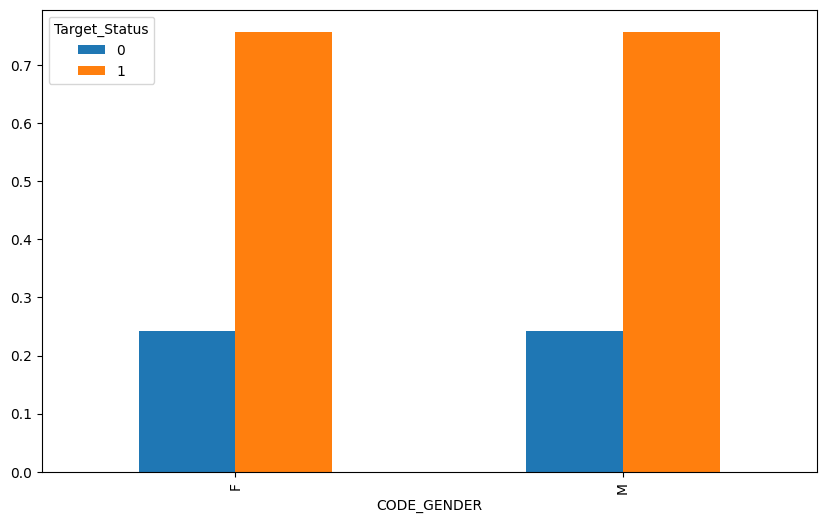

In [192]:
df_poutcome_dependent_ratio = pd.crosstab(df[list_categorical_columns[0]], df[target_column], normalize='index')
df_poutcome_dependent_ratio.plot.bar(figsize=(10, 6))

<Figure size 3000x3000 with 0 Axes>

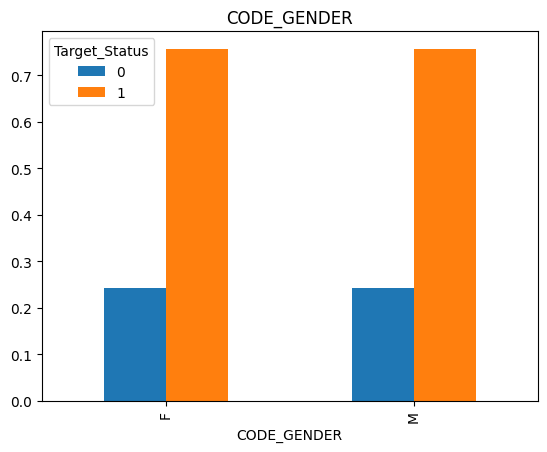

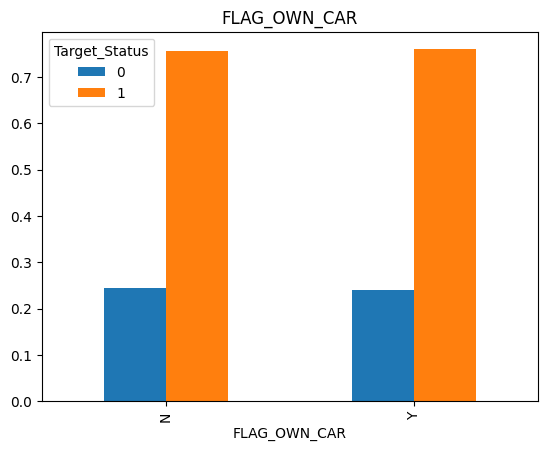

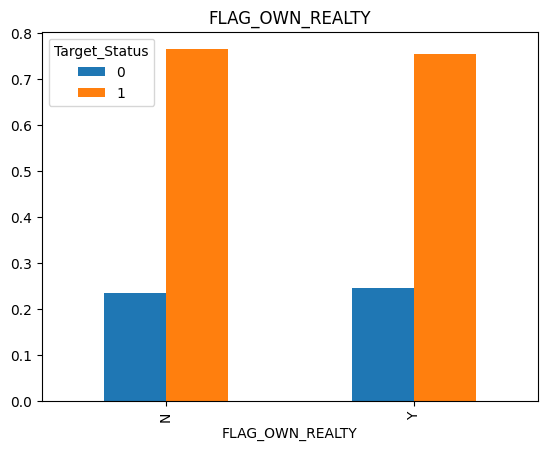

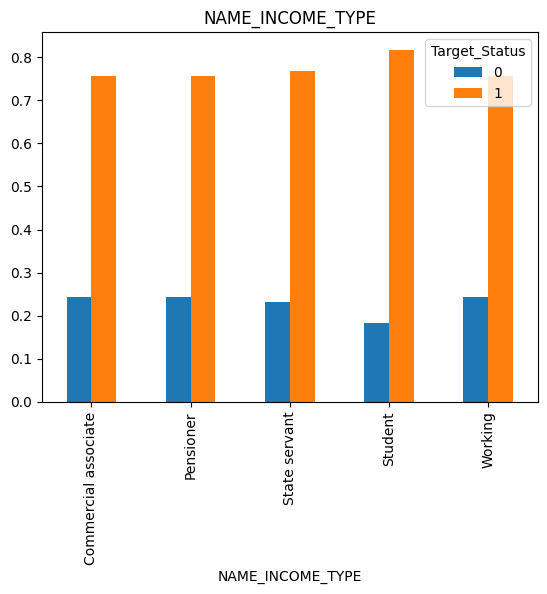

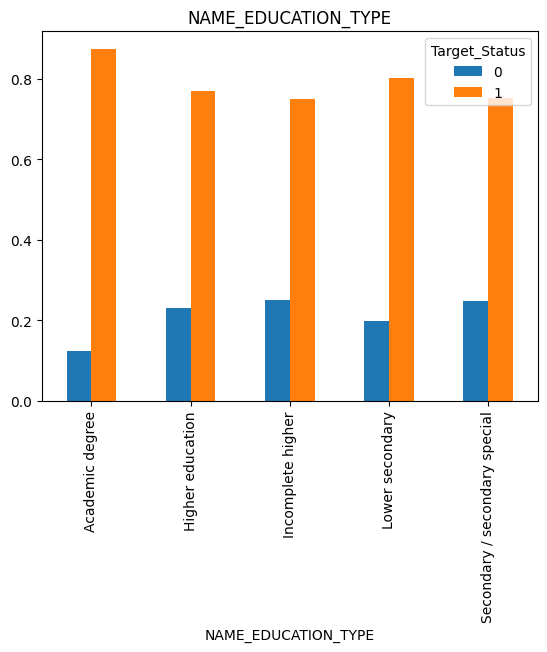

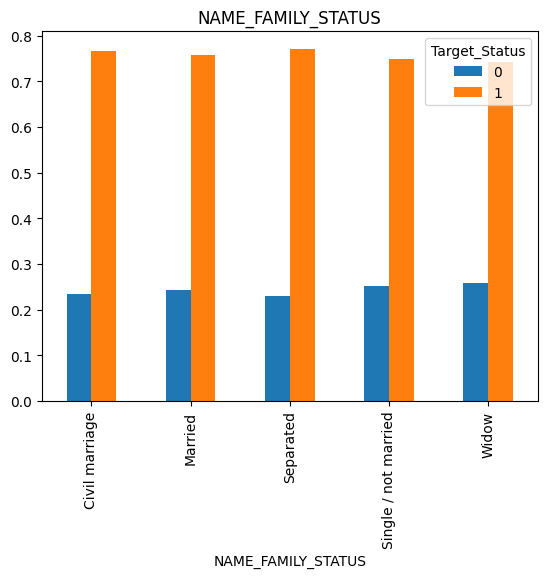

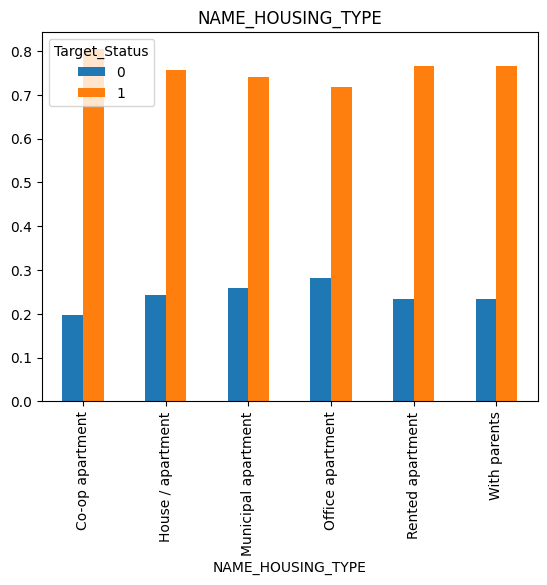

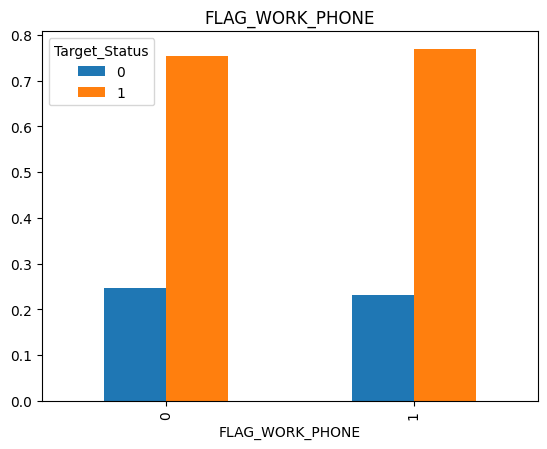

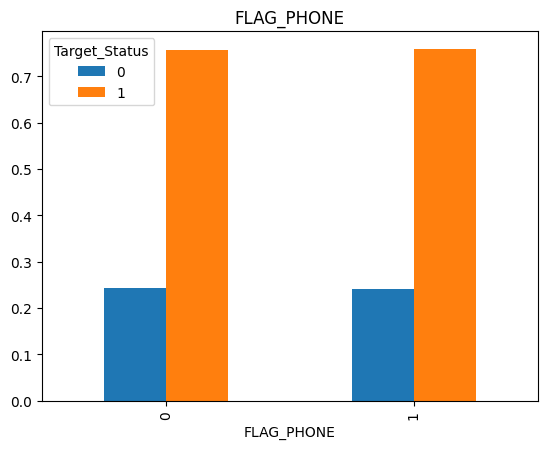

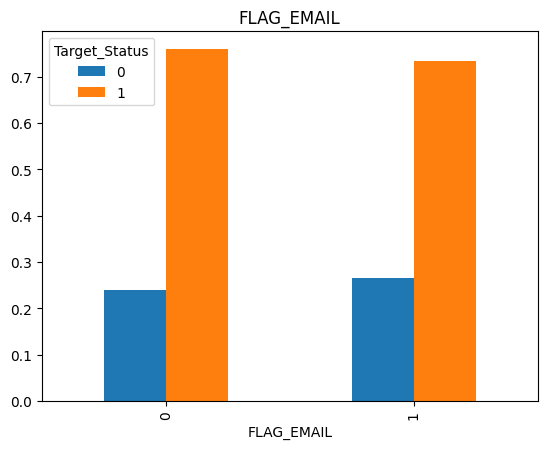

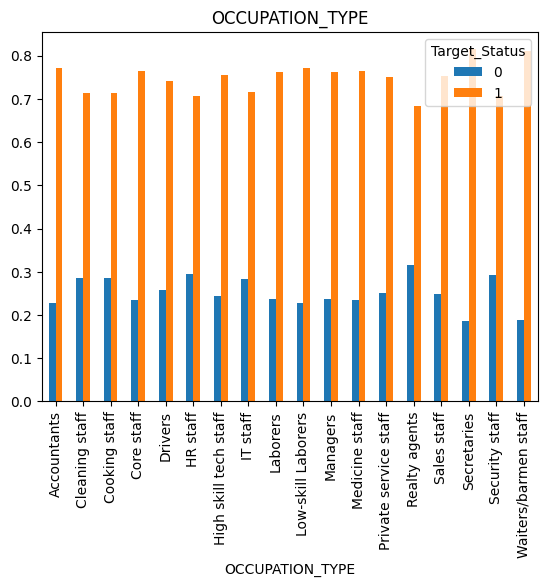

In [193]:
plt.figure(figsize=(30, 30))
for column_name in list_categorical_columns:
    pd.crosstab(df[column_name], df[target_column], normalize='index').plot.bar()
    plt.title(column_name)
plt.show()

In [194]:
list_meaningful_column_by_chi = []
for column_name in list_categorical_columns:
    statistic, pvalue, _, _ = chi2_contingency(pd.crosstab(df[target_column], df[column_name]))
    if pvalue <= 0.05:
        list_meaningful_column_by_chi.append(column_name)
    print(column_name, ", ", statistic, ", ", pvalue)

print("all categorical columns : ", len(list_categorical_columns))
print("selected columns by chi : ", len(list_meaningful_column_by_chi), list_meaningful_column_by_chi)

CODE_GENDER ,  9.14917437672138e-06 ,  0.9975865942019964
FLAG_OWN_CAR ,  0.5098662708631283 ,  0.4751967521310614
FLAG_OWN_REALTY ,  4.977225226185185 ,  0.025683144705680533
NAME_INCOME_TYPE ,  2.01113474585598 ,  0.7337107708524153
NAME_EDUCATION_TYPE ,  18.572087173370093 ,  0.0009536101652285508
NAME_FAMILY_STATUS ,  7.550663604106124 ,  0.10949588140271563
NAME_HOUSING_TYPE ,  6.989183690226566 ,  0.22144597438992644
FLAG_WORK_PHONE ,  8.161893932932294 ,  0.004277967441616775
FLAG_PHONE ,  0.141973825352162 ,  0.7063265945457923
FLAG_EMAIL ,  10.15955131332863 ,  0.0014355555483766811
OCCUPATION_TYPE ,  37.75898732078343 ,  0.00265220666581643
all categorical columns :  11
selected columns by chi :  5 ['FLAG_OWN_REALTY', 'NAME_EDUCATION_TYPE', 'FLAG_WORK_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE']


In [195]:
### to do ###
df[list_numeric_columns].nunique().sort_values()

CNT_CHILDREN           9
CNT_FAM_MEMBERS       10
MONTHS_BALANCE        61
AMT_INCOME_TOTAL     265
DAYS_EMPLOYED       3640
DAYS_BIRTH          7183
dtype: int64

In [196]:
df[list_numeric_columns].describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,MONTHS_BALANCE
count,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.000000,36457.000000
mean,0.430315,1.866857e+05,-15975.173382,59262.935568,2.198453,-5.831802
std,0.742367,1.017892e+05,4200.549944,137651.334859,0.911686,11.326494
min,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.000000,-60.000000
25%,0.000000,1.215000e+05,-19438.000000,-3153.000000,2.000000,-6.000000
50%,0.000000,1.575000e+05,-15563.000000,-1552.000000,2.000000,0.000000
75%,1.000000,2.250000e+05,-12462.000000,-408.000000,3.000000,0.000000
max,19.000000,1.575000e+06,-7489.000000,365243.000000,20.000000,0.000000


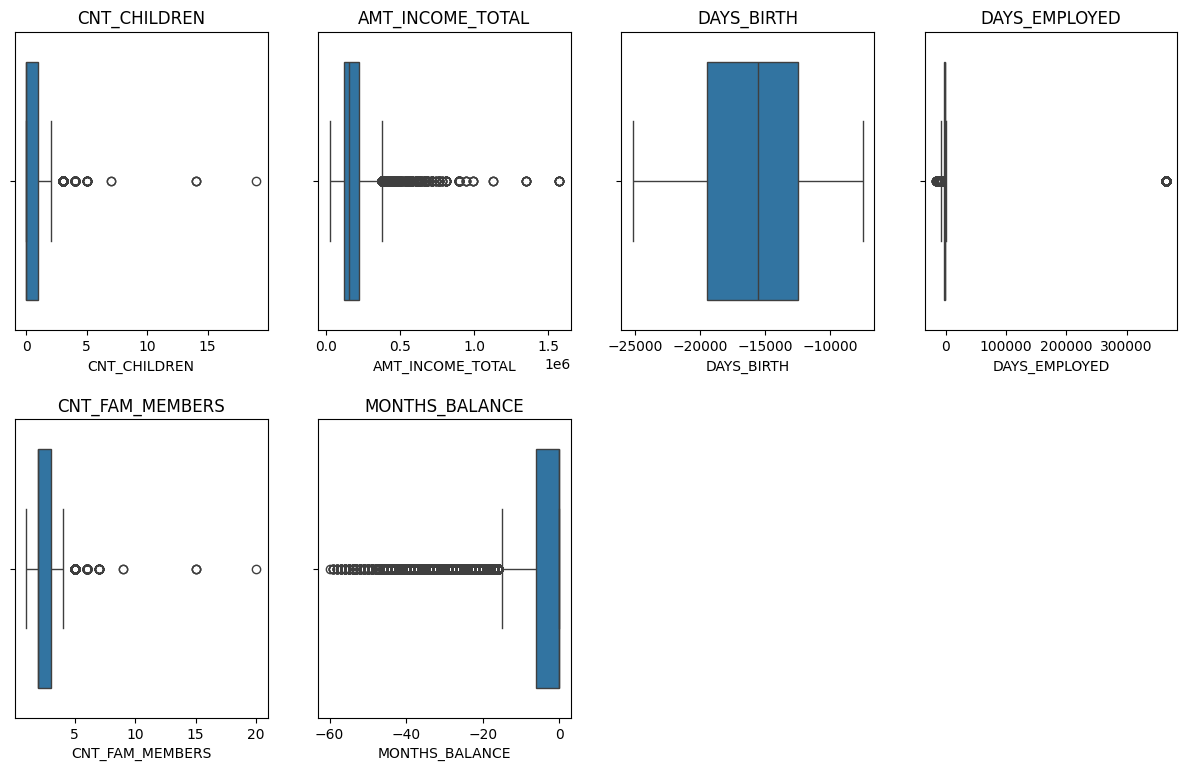

In [197]:
plt.figure(figsize=(15,7))
x = 1
plt.subplots_adjust(top=0.99, bottom=0.01, hspace=0.3, wspace=0.2)
for column_name in list_numeric_columns:
    plt.subplot(2, 4, x)
    x = x + 1
    sns.boxplot(x=column_name, data=df)
    plt.title(column_name)

plt.show()

In [198]:
for column_name in list_numeric_columns:
    print(column_name, "skew: ", skew(df[column_name]), "kur : ", kurtosis(df[column_name]))

CNT_CHILDREN skew:  2.5692764853112635 kur :  22.55917511845248
AMT_INCOME_TOTAL skew:  2.738897180151655 kur :  17.595506164509793
DAYS_BIRTH skew:  -0.18422206947290823 kur :  -1.045664746406706
DAYS_EMPLOYED skew:  1.7723702515885982 kur :  1.1430772697054437
CNT_FAM_MEMBERS skew:  1.298542476962789 kur :  8.187407769180325
MONTHS_BALANCE skew:  -2.1378871685624534 kur :  3.918957344284352


<Axes: >

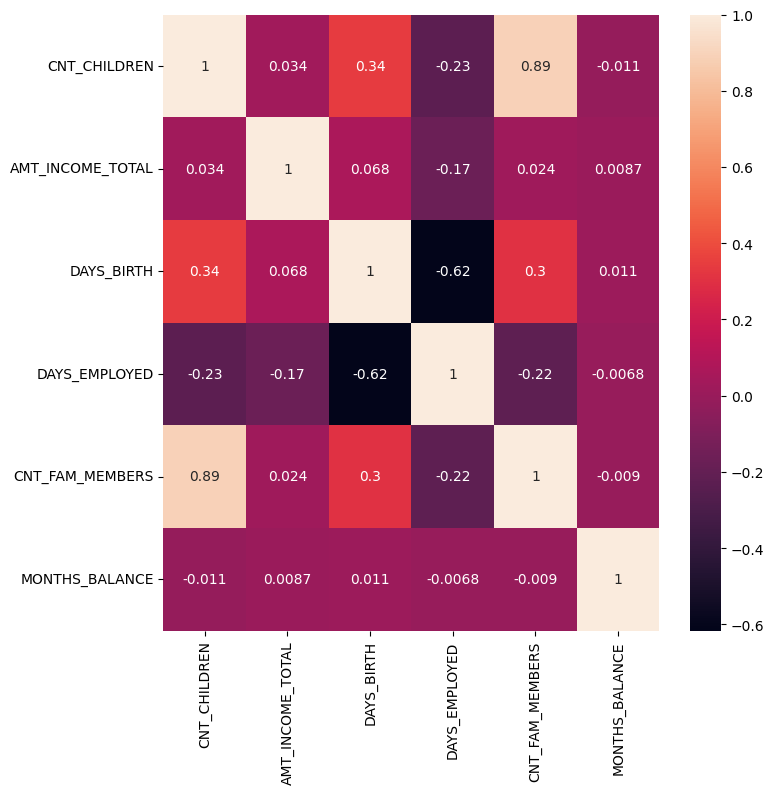

In [199]:
df_corr = df[list_numeric_columns].corr()
plt.figure(figsize=(8, 8))

sns.heatmap(df_corr, annot=True)

In [200]:
index_corr_over_85 = np.where((abs(df_corr)>0.85) & (df_corr != 1))
index_corr_over_85

(array([0, 4]), array([4, 0]))

In [201]:
statistic, pvalue = stats.pearsonr(df.loc[:, "CNT_FAM_MEMBERS"], df.loc[:, "CNT_CHILDREN"])
print(statistic)
print(pvalue)

0.8891141560150977
0.0


In [202]:
def calculate_vif(df_target):
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(df_target.values, i) for i in range(df_target.shape[1])]
    vif["Feature"] = df_target.columns
    return vif

df_vif = df[list_numeric_columns].copy()

In [203]:
calculate_vif(df[list_numeric_columns])


,VIF_Factor,Feature
0,5.501891,CNT_CHILDREN
1,4.177863,AMT_INCOME_TOTAL
2,13.927450,DAYS_BIRTH
3,1.814530,DAYS_EMPLOYED
4,20.422667,CNT_FAM_MEMBERS
5,1.259641,MONTHS_BALANCE


In [204]:
calculate_vif(df[list_numeric_columns].drop("CNT_FAM_MEMBERS", axis=1))

,VIF_Factor,Feature
0,1.317477,CNT_CHILDREN
1,4.030542,AMT_INCOME_TOTAL
2,5.406126,DAYS_BIRTH
3,1.665757,DAYS_EMPLOYED
4,1.256456,MONTHS_BALANCE


In [205]:
list_numeric_feature_by_vif = list_numeric_columns.copy()
list_numeric_feature_by_vif.remove("CNT_FAM_MEMBERS")

In [206]:
list_numeric_feature_by_vif

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'MONTHS_BALANCE']

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

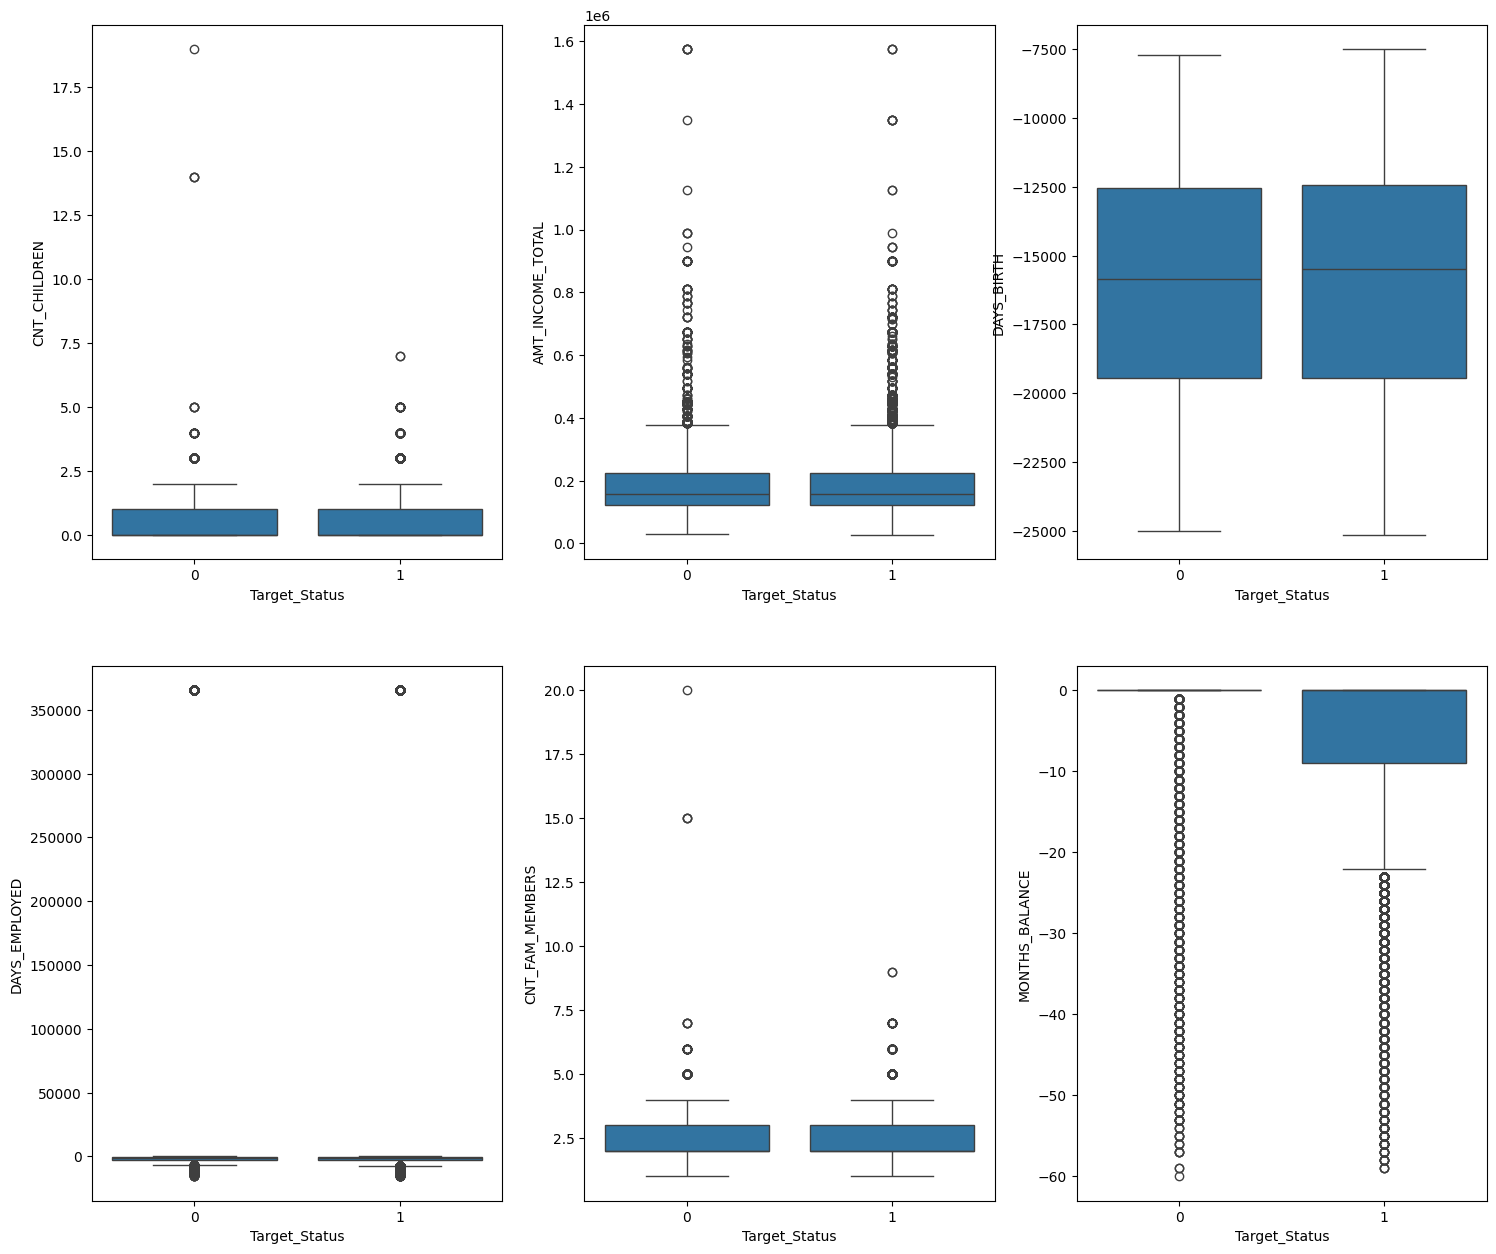

In [207]:
plt.figure(figsize=(18, 12))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.2, wspace=0.2)
for column_name in list_numeric_columns:
    plt.subplot(2, 3, x)
    x = x + 1
    sns.boxplot(data=df, x=target_column, y=column_name)
plt.show()

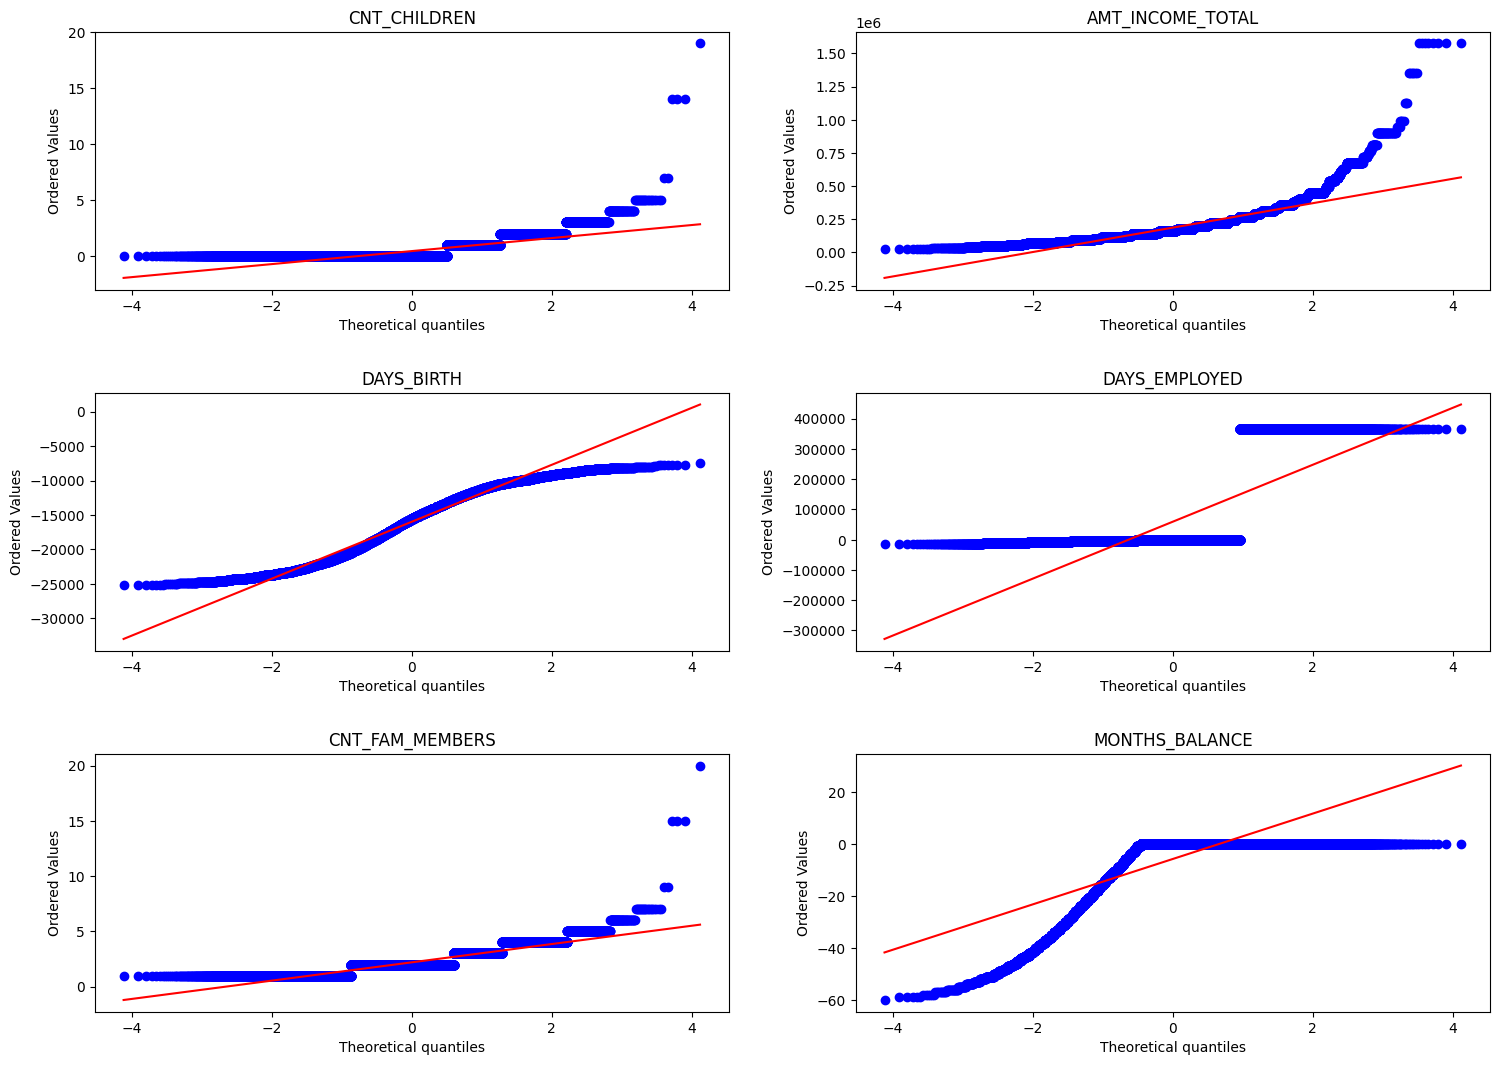

In [208]:
plt.figure(figsize=(18, 10))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.2)
for column_name in list_numeric_columns:
    plt.subplot(3, 2, x)
    x = x + 1
    stats.probplot(df[column_name], dist=stats.norm, plot=plt)
    plt.title(column_name)
plt.show()

In [209]:
list_column_normality = []
for column_name in list_numeric_columns:
    statistic, pvalue = stats.shapiro(df[column_name])
    if pvalue >= 0.05:
        list_column_normality.append(column_name)
    print(column_name, ", statistic : ", statistic, ", plvalue : ", pvalue)

print("정규성 만죽하는 column 수 : ", len(list_column_normality))

CNT_CHILDREN , statistic :  0.6152937705806769 , plvalue :  2.2142495006866363e-125
AMT_INCOME_TOTAL , statistic :  0.8168496452628089 , plvalue :  4.158438860652268e-105
DAYS_BIRTH , statistic :  0.966297111706394 , plvalue :  1.1692021521154388e-65
DAYS_EMPLOYED , statistic :  0.46610934407707916 , plvalue :  6.535805462011858e-135
CNT_FAM_MEMBERS , statistic :  0.8236549801777469 , plvalue :  4.0234495421358244e-104
MONTHS_BALANCE , statistic :  0.591912578199909 , plvalue :  4.524659155950623e-127
정규성 만죽하는 column 수 :  0


/data/ephemeral/home/envs/mlops/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 36457.
  res = hypotest_fun_out(*samples, **kwds)


In [210]:
list_target_unique = df[target_column].unique()
list_meaningful_column_by_kruskall = []

for column_name in list_numeric_columns:
    list_by_quality_value = []
    for quality_value in list_target_unique:
        df_tmp = df[df[target_column] == quality_value][column_name].dropna()
        list_by_quality_value.append(np.array(df_tmp))

    statistic, pvalue = kruskal(*list_by_quality_value)
    if pvalue <= 0.05:
        list_meaningful_column_by_kruskall.append(column_name)

    print(column_name, ", ", statistic, ", ", pvalue)
print("all numerical columns : ", len(list_numeric_columns))
print("selected columns by kruskal : ", len(list_meaningful_column_by_kruskall), list_meaningful_column_by_kruskall)

CNT_CHILDREN ,  0.9337989725891732 ,  0.33387770621591706
AMT_INCOME_TOTAL ,  0.5387857888480218 ,  0.46293637094856877
DAYS_BIRTH ,  2.1336943086384164 ,  0.1440931072120902
DAYS_EMPLOYED ,  25.523534603497747 ,  4.370195260220316e-07
CNT_FAM_MEMBERS ,  0.9386094371351926 ,  0.33263571559306976
MONTHS_BALANCE ,  945.4711171201508 ,  1.280009852962771e-207
all numerical columns :  6
selected columns by kruskal :  2 ['DAYS_EMPLOYED', 'MONTHS_BALANCE']


In [211]:
list_selected_numerical = list_meaningful_column_by_kruskall.copy()

In [212]:
df_fs = df[list_meaningful_column_by_chi + list_selected_numerical + [target_column]]
df_fs.head(2)

,FLAG_OWN_REALTY,NAME_EDUCATION_TYPE,FLAG_WORK_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,DAYS_EMPLOYED,MONTHS_BALANCE,Target_Status
0,Y,Higher education,1,0,NaN,-4542,0,1
1,Y,Higher education,1,0,NaN,-4542,0,1


In [213]:
df_fs.isna().sum()

FLAG_OWN_REALTY            0
NAME_EDUCATION_TYPE        0
FLAG_WORK_PHONE            0
FLAG_EMAIL                 0
OCCUPATION_TYPE        11323
DAYS_EMPLOYED              0
MONTHS_BALANCE             0
Target_Status              0
dtype: int64

In [214]:
df["OCCUPATION_TYPE"].dtype

dtype('O')

In [215]:
Y = df_fs[target_column]
X = df_fs.drop([target_column], axis=1)

In [216]:
Y

0        1
1        1
2        1
3        0
4        1
        ..
36452    0
36453    1
36454    1
36455    0
36456    0
Name: Target_Status, Length: 36457, dtype: object

In [217]:
le = LabelEncoder()
le.fit(Y)
Y_encoded = le.transform(Y)

In [218]:
Y_encoded

array([1, 1, 1, ..., 1, 0, 0])

In [219]:
list_categorical_columns = list(df_fs.select_dtypes(include=['object']).columns)
lsit_numeric_columns = list(df_fs.select_dtypes(include=['float64', 'int64']).columns)
print(len(list_categorical_columns))
print(len(lsit_numeric_columns))

6
2


In [220]:
scaler_minmax = MinMaxScaler()
X.loc[:, list_selected_numerical] = scaler_minmax.fit_transform(X[list_selected_numerical])
X.head(1)

,FLAG_OWN_REALTY,NAME_EDUCATION_TYPE,FLAG_WORK_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,DAYS_EMPLOYED,MONTHS_BALANCE
0,Y,Higher education,1,0,NaN,0.029324,1.0


In [221]:
X_base = pd.get_dummies(X)
X_base.head(1)

,DAYS_EMPLOYED,MONTHS_BALANCE,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,FLAG_WORK_PHONE_0,...,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff
0,0.029324,1.0,False,True,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [222]:
X_train, X_validation, y_train, y_validation = train_test_split(X_base, Y_encoded, test_size=0.2, stratify=Y_encoded)

In [223]:
sm = SMOTE(random_state=random_state)
X_sm_sampling, y_sm_sampling = sm.fit_resample(X_train, y_train)

2025/06/01 18:05:24 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: RESOURCE_DOES_NOT_EXIST: Could not find experiment with ID 190436951373626940


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'After sampling for target label')

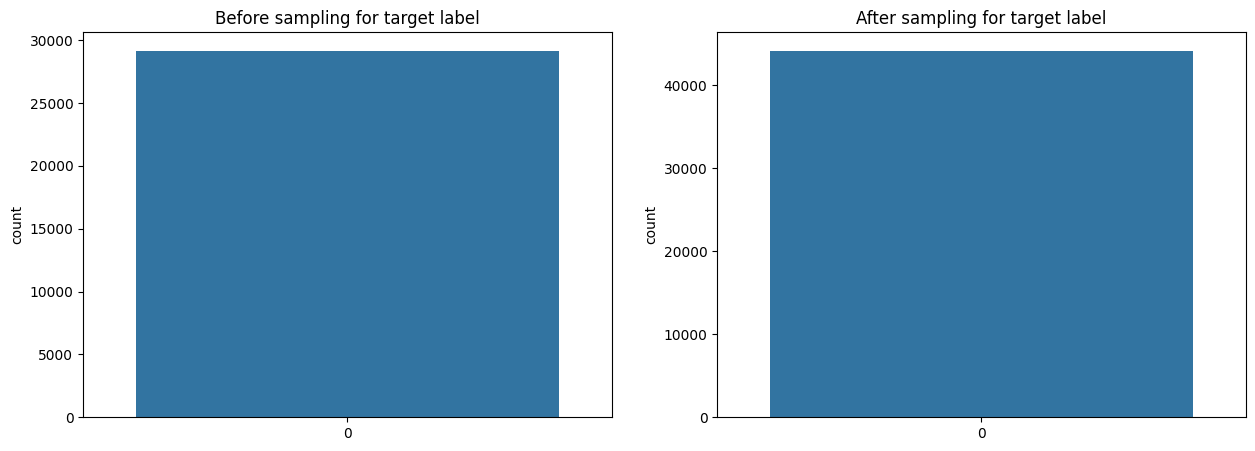

In [224]:
fig = plt.figure(figsize=(15, 5))
fig.add_subplot(121)
sns.countplot(data=pd.DataFrame(y_train))
plt.title("Before sampling for target label")

fig.add_subplot(122)
sns.countplot(data=pd.DataFrame(y_sm_sampling))
plt.title("After sampling for target label")

In [225]:
combined_sm = SMOTEENN(random_state=random_state)
X_csm_sampling, y_csm_sampling = combined_sm.fit_resample(X_train, y_train)

2025/06/01 18:05:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: RESOURCE_DOES_NOT_EXIST: Could not find experiment with ID 190436951373626940
2025/06/01 18:05:25 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: RESOURCE_DOES_NOT_EXIST: Could not find experiment with ID 190436951373626940


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'After sampling for target label')

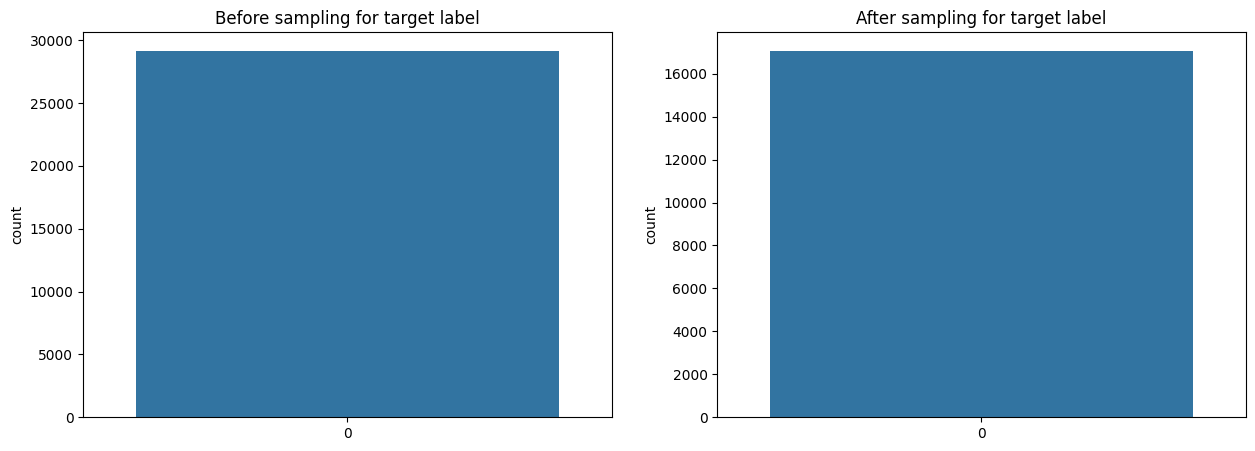

In [226]:
fig = plt.figure(figsize=(15, 5))
fig.add_subplot(121)
sns.countplot(data=pd.DataFrame(y_train))
plt.title("Before sampling for target label")

fig.add_subplot(122)
sns.countplot(data=pd.DataFrame(y_csm_sampling))
plt.title("After sampling for target label")

In [227]:
list_model_type = []
list_model_best_params = []
list_model_f1_score = []
cv = 3
n_iter_randomsearch = 40

In [228]:
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X_train, y_train)

3

In [244]:
import mlflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")

In [245]:
mlflow.set_experiment("credit_approval_ml_fc2")

<Experiment: artifact_location='mlflow-artifacts:/769979773475767134', creation_time=1748768726565, experiment_id='769979773475767134', last_update_time=1748768726565, lifecycle_stage='active', name='credit_approval_ml_fc2', tags={}>

In [232]:
mlflow.sklearn.autolog()

In [233]:
list_fold_result = []
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    X_train_cv, X_test_cv = X_train.iloc[train_index, :], X_train.iloc[test_index, :]
    y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
    rf_clf = MLPClassifier(hidden_layer_sizes=10)
    rf_clf.fit(X_train_cv, y_train_cv)
    y_prd_test = rf_clf.predict(X_test_cv)
    y_prd_proba_test = rf_clf.predict_proba(X_test_cv)[:,-1]
    prf_score_test = precision_recall_fscore_support(y_test_cv, y_prd_test, average="macro")
    score_test = roc_auc_score(y_test_cv, y_prd_proba_test)
    print(i, " precision, recall, f1score : ", prf_score_test)
    print(i, " roc_auc_score : ", score_test)

    y_prd_validation = rf_clf.predict(X_validation)
    y_prd_proba_validation = rf_clf.predict_proba(X_validation)[:, -1]
    prf_score_validation = precision_recall_fscore_support(y_validation, y_prd_validation, average="macro")
    score_validation = roc_auc_score(y_validation, y_prd_proba_validation)
    print(i, " precision, recall, f1score : ", prf_score_test)
    print(i, " roc_auc_score : ", score_test)
    list_fold_result.append(prf_score_validation[2])
    mlflow.log_param("feature_type", "base feature")

f1score_final = np.mean(list_fold_result)
print("average roc auc score : ", f1score_final)
list_model_type.append("Base model without sampling")
list_model_best_params.append({})
list_model_f1_score.append(f1score_final)

2025/06/01 18:05:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c79a9acccf364d8cbeb67643aff99cc2', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run hilarious-calf-600 at: http://localhost:5000/#/experiments/769979773475767134/runs/c79a9acccf364d8cbeb67643aff99cc2
🧪 View experiment at: http://localhost:5000/#/experiments/769979773475767134
0  precision, recall, f1score :  (0.6646128961105802, 0.5006448702871457, 0.4327224923421978, None)
0  roc_auc_score :  0.5789685992613184
0  precision, recall, f1score :  (0.6646128961105802, 0.5006448702871457, 0.4327224923421978, None)
0  roc_auc_score :  0.5789685992613184
1  precision, recall, f1score :  (0.6012835940633774, 0.501527278885877, 0.4358659134361944, None)
1  roc_auc_score :  0.5886976753965668
1  precision, recall, f1score :  (0.6012835940633774, 0.501527278885877, 0.4358659134361944, None)
1  roc_auc_score :  0.5886976753965668
2  precision, recall, f1score :  (0.612325709183323, 0.5009424594598644, 0.43391713487972833, None)
2  roc_auc_score :  0.5896559404884987
2  precision, recall, f1score :  (0.612325709183323, 0.5009424594598644, 0.43391713487972833, None)
2  

🏃 View run stately-boar-1 at: http://localhost:5000/#/experiments/769979773475767134/runs/f7adbdf1b127437498e05cef458f2a4e
🧪 View experiment at: http://localhost:5000/#/experiments/769979773475767134
🏃 View run delightful-koi-222 at: http://localhost:5000/#/experiments/769979773475767134/runs/a21ca1a58cf141689b1d4dc928667a3a
🧪 View experiment at: http://localhost:5000/#/experiments/769979773475767134
🏃 View run nosy-squirrel-750 at: http://localhost:5000/#/experiments/769979773475767134/runs/af423c0ae6ed451584bbeb37256b40d4
🧪 View experiment at: http://localhost:5000/#/experiments/769979773475767134


In [234]:
def plot_roc_auc(y_true, y_prd_proba):
    fpr, tpr, _ = roc_curve(y_true, y_prd_proba)
    auc = roc_auc_score(y_true, y_prd_proba)
    plt.figure(figsize=(7, 7))
    plt.plot(fpr,tpr,label="auc="+str(auc))
    plt.legend(loc=4)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

In [235]:
mlflow.end_run()

🏃 View run efficient-sloth-89 at: http://localhost:5000/#/experiments/769979773475767134/runs/726efbdc701f454482f6a21cb12b228f
🧪 View experiment at: http://localhost:5000/#/experiments/769979773475767134


In [236]:
def model_learning_with_randomsearch(model, hyper_parameter, X, Y, feature_type="base_feature", metric="roc_auc"):
    with mlflow.start_run():
        random_cv_opt = RandomizedSearchCV(estimator=model, param_distributions=hyper_parameter, n_iter=n_iter_randomsearch, cv = cv, random_state=random_state, scoring=metric, verbose=1)
        random_cv_opt.fit(X, Y)
        y_prd = random_cv_opt.predict(X_validation)
        mlflow.log_param("feature_type",feature_type)
        prf_score = precision_recall_fscore_support(y_validation, y_prd, average="macro")
        y_prd_proba = random_cv_opt.predict_proba(X_validation)[:,-1]
        score = roc_auc_score(y_validation, y_prd_proba)
        print('validation -> best model hyper-parameter : ', random_cv_opt.best_params_)
        print('validation -> precision, recall, f1score : ', prf_score)
        print('validation -> roc_auc_score : ', score)

        cm = pd.DataFrame(confusion_matrix(y_validation, y_prd))
        sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d')
    
    return random_cv_opt.best_params_, prf_score, prf_score[2]

/data/ephemeral/home/envs/mlops/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 32 is smaller than n_iter=40. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 32 candidates, totalling 96 fits


/data/ephemeral/home/envs/mlops/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2025/06/01 18:08:41 INFO mlflow.sklearn.utils: Logging the 5 best runs, 27 runs will be omitted.


🏃 View run stately-kit-50 at: http://localhost:5000/#/experiments/769979773475767134/runs/98a4c483b34d4e8f884ba6b1e5f10671
🧪 View experiment at: http://localhost:5000/#/experiments/769979773475767134
🏃 View run gentle-shad-763 at: http://localhost:5000/#/experiments/769979773475767134/runs/75973d0bbb134c229ff8064dfc9e3e49
🧪 View experiment at: http://localhost:5000/#/experiments/769979773475767134
🏃 View run selective-sheep-759 at: http://localhost:5000/#/experiments/769979773475767134/runs/d3c8e22a21364a6da89d52e39ada8db5
🧪 View experiment at: http://localhost:5000/#/experiments/769979773475767134
🏃 View run brawny-hare-256 at: http://localhost:5000/#/experiments/769979773475767134/runs/c1296977780f449c84123e99e8a76c44
🧪 View experiment at: http://localhost:5000/#/experiments/769979773475767134


/data/ephemeral/home/envs/mlops/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


validation -> best model hyper-parameter :  {'warm_start': False, 'solver': 'adam', 'power_t': 0.5, 'learning_rate_init': 0.01, 'learning_rate': 'constant', 'hidden_layer_sizes': 25, 'early_stopping': True, 'alpha': 0.0001, 'activation': 'tanh'}
validation -> precision, recall, f1score :  (0.3787712561711465, 0.5, 0.43102372034956304, None)
validation -> roc_auc_score :  0.5701725051687249
🏃 View run grandiose-roo-553 at: http://localhost:5000/#/experiments/769979773475767134/runs/2de3ea0dca9f41ffa9ad35a3237e1fd5
🧪 View experiment at: http://localhost:5000/#/experiments/769979773475767134


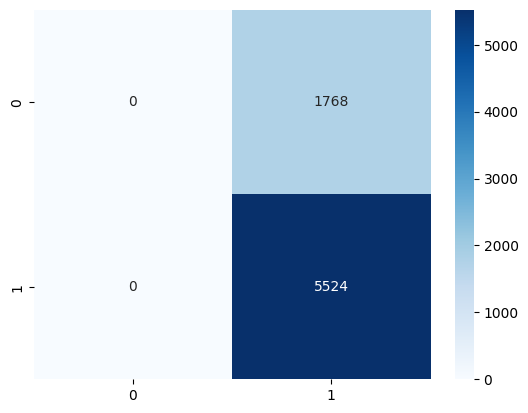

🏃 View run smiling-gnu-907 at: http://localhost:5000/#/experiments/769979773475767134/runs/ecafe9233f434142bf31a8714bd8749d
🧪 View experiment at: http://localhost:5000/#/experiments/769979773475767134
🏃 View run sincere-ox-393 at: http://localhost:5000/#/experiments/769979773475767134/runs/e017a55832114112b10aa5fbb7c2a081
🧪 View experiment at: http://localhost:5000/#/experiments/769979773475767134
🏃 View run amusing-fowl-543 at: http://localhost:5000/#/experiments/769979773475767134/runs/5f3fe1da45f8457b89d83109d23a2c70
🧪 View experiment at: http://localhost:5000/#/experiments/769979773475767134
🏃 View run judicious-duck-962 at: http://localhost:5000/#/experiments/769979773475767134/runs/5f39a547006f4942a23b66dd6a2936da
🧪 View experiment at: http://localhost:5000/#/experiments/769979773475767134
🏃 View run rare-trout-952 at: http://localhost:5000/#/experiments/769979773475767134/runs/57adbca4d7384e46b09ed025728bfb61
🧪 View experiment at: http://localhost:5000/#/experiments/769979773475

In [237]:
hyper_params_mlp = {
    'hidden_layer_sizes': [10, 15, 20, 25],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant'],
    'learning_rate_init': [0.001, 0.01],
    'power_t': [0.5],
    'alpha': [0.0001],
    'early_stopping': [True],
    'warm_start': [False],

}

params, prf_score, score = model_learning_with_randomsearch(MLPClassifier(), hyper_params_mlp, X_base, Y_encoded, feature_type="base_feature")
list_model_type.append("model optimiztaion with base feature")
list_model_best_params.append(params)
list_model_f1_score.append(score)

/data/ephemeral/home/envs/mlops/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 32 is smaller than n_iter=40. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 32 candidates, totalling 96 fits


2025/06/01 18:16:08 INFO mlflow.sklearn.utils: Logging the 5 best runs, 27 runs will be omitted.


validation -> best model hyper-parameter :  {'warm_start': False, 'solver': 'adam', 'power_t': 0.5, 'learning_rate_init': 0.01, 'learning_rate': 'constant', 'hidden_layer_sizes': 20, 'early_stopping': True, 'alpha': 0.0001, 'activation': 'relu'}
validation -> precision, recall, f1score :  (0.555975763052267, 0.5730936333760375, 0.4892334144674201, None)
validation -> roc_auc_score :  0.5927627407839424
🏃 View run brawny-gnu-774 at: http://localhost:5000/#/experiments/769979773475767134/runs/c6c310a15c354e1db818b9accbad0666
🧪 View experiment at: http://localhost:5000/#/experiments/769979773475767134


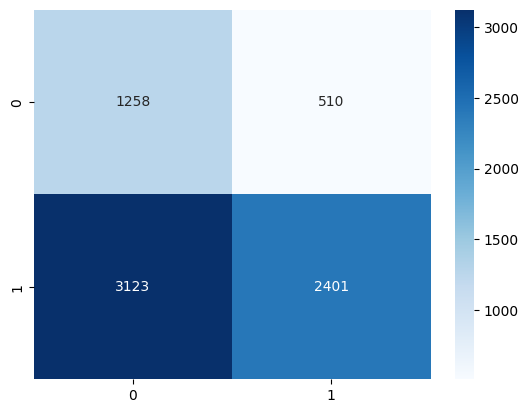

In [238]:
params, prf_score, score = model_learning_with_randomsearch(MLPClassifier(), hyper_params_mlp, X_sm_sampling, y_sm_sampling, feature_type="smote oversampling")
list_model_type.append("model optimiztaion with smote oversampling")
list_model_best_params.append(params)
list_model_f1_score.append(score)

/data/ephemeral/home/envs/mlops/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 32 is smaller than n_iter=40. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 32 candidates, totalling 96 fits


2025/06/01 18:20:10 INFO mlflow.sklearn.utils: Logging the 5 best runs, 27 runs will be omitted.


validation -> best model hyper-parameter :  {'warm_start': False, 'solver': 'adam', 'power_t': 0.5, 'learning_rate_init': 0.01, 'learning_rate': 'constant', 'hidden_layer_sizes': 25, 'early_stopping': True, 'alpha': 0.0001, 'activation': 'tanh'}
validation -> precision, recall, f1score :  (0.5397591861643174, 0.5383179855242939, 0.5389063695715183, None)
validation -> roc_auc_score :  0.5679425710433452
🏃 View run able-squirrel-607 at: http://localhost:5000/#/experiments/769979773475767134/runs/b7f3ab4cd8554a9280315fb0a0fa5a79
🧪 View experiment at: http://localhost:5000/#/experiments/769979773475767134


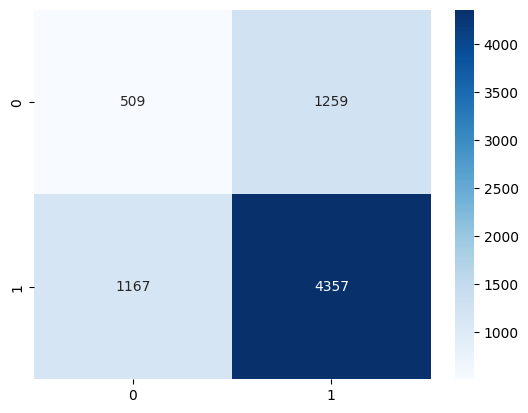

In [239]:
params, prf_score, score = model_learning_with_randomsearch(MLPClassifier(), hyper_params_mlp, X_csm_sampling, y_csm_sampling, feature_type="smoteenn combined oversampling")
list_model_type.append("model optimiztaion with smote oversampling")
list_model_best_params.append(params)
list_model_f1_score.append(score)

In [246]:
import mlflow.pyfunc

model_name = "creditapprovalmodel"

alias = "bestmodel"

loaded_model = mlflow.pyfunc.load_model(f"models:/{model_name}@{alias}")

In [247]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: model
  flavor: mlflow.sklearn
  run_id: b7f3ab4cd8554a9280315fb0a0fa5a79

In [248]:
y_prd_production = loaded_model.predict(X_validation)

In [249]:
y_prd_production
prf_score_production = precision_recall_fscore_support(y_validation, y_prd_production, average="macro")
score_production = roc_auc_score(y_validation, y_prd_production)

print(prf_score_production)
print(score_production)

(0.5397591861643174, 0.5383179855242939, 0.5389063695715183, None)
0.5383179855242939


In [ ]:
import pandas as pd
import requests

host = "127.0.0.1"
url = f"http://{host}:5001/invocations"

json_data = {"dataframe_split": X_validation[:10].to_dict(orient="split")}

response = requests.post(url, json=json_data)
print(f"\nPyfunc 'predict_interval':\n${response.json()}")

In [8]:
import urllib3
urllib3.connectionpool.HTTPConnectionPool(host='127.0.0.1', port=5000)

In [78]:
mlp_final = MLPClassifier(**{'warm_start': False, 'solver': 'adam', 'power_t': 0.5, 'max_iter': 10000, 'learning_rate_init': 0.01, 'learning_rate': 'constant', 'hidden_layer_sizes': 25, 'early_stopping': True, 'alpha': 0.0001, 'activation': 'relu'})
mlp_final.fit(X_csm_sampling, y_csm_sampling)

MLPClassifier(early_stopping=True, hidden_layer_sizes=25,
              learning_rate_init=0.01, max_iter=10000)

In [83]:
X_validation_clean = X_validation.astype(float)
explainer = shap.Explainer(lambda x : mlp_final.predict_log_proba(x)[:,1], X_validation_clean)
shap_values = explainer(X_validation_clean)

PermutationExplainer explainer: 7293it [14:17,  8.44it/s]                          


/tmp/ipykernel_1504538/3788798118.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_validation)


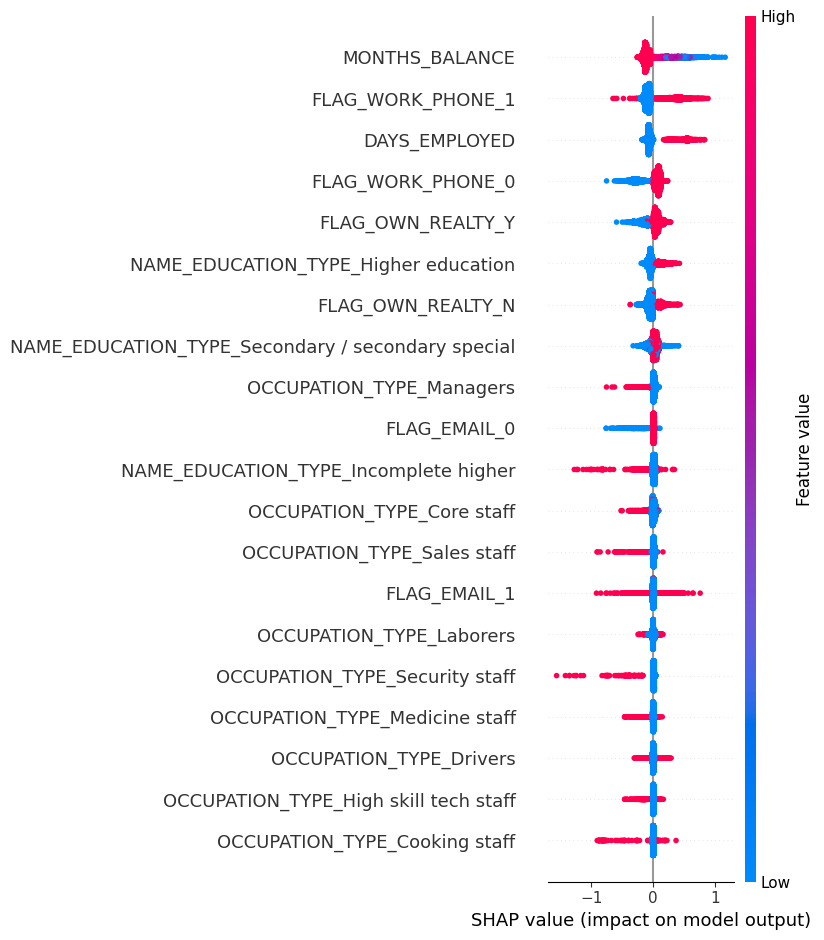

In [84]:
shap.summary_plot(shap_values, X_validation)